In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# market_data.csv 1min freq 50 US stocks for 3 months (only bid/ask prices are provided, not volumes)
market_data = pd.read_csv('market_data.csv')

# orders.csv: contains the orders generated by the pseudo-algo strategy, with information such as date, timestamp, symbol, order_status, price, side, quantity, order_id. The trades are contained in the orders with order_status = FILL.
order = pd.read_csv('orders.csv')

In [3]:
market_data.dtypes

date          object
timestamp     object
symbol        object
bid_price    float64
ask_price    float64
dtype: object

In [4]:
order.dtypes

date             object
timestamp        object
symbol           object
order_status     object
price           float64
side             object
quantity        float64
order_id         object
dtype: object

# Market risk

##  1.1 Metrics to monitor the market risk of the cash equity strategy

We have market risk when we have exposure created by FILL status order. Because only orders with FILL status create real market exposure while CREATE or Cancel will not create real exposure.

Since alpha has horizon of about 30 minutes, risk metrics will be evaluated over the 30-minute window following each FILL.

Since we only have bid ask price, we use mid price (=(bid+ask)/2) to show the actual price for the stock

------
Metrics we can consider include 

1. **Dollar Delta exposure** = sum(position(i) * mid(i)) i = 1...n, representing ith asset 

    instantaneous directional exposure of the portfolio

    since it is a cash equity stategy, we can cal dollar(or other quote currency) delta exposure with position * mid price

2. **30-min price volatility exposure** 

    realized_vol = std(mid[t+1],...,mid[t+30]) each step is 1min
    
    vol_risk = realized_vol * abs(position)

    Market risk is proportional to position size and volatility

3. **30-min maximum adverse price move**

    for buy fill: max_adverse_price_mov = min(mid[t:t+30])-fill_price

    for sell fill: max_adverse_price_mov = max(mid[t:t+30])-fill_price

    MAM shows tail risk. It shows worst profit in following 30-min window    

    MAM works better than VaR or CVaR. VaR and CVaR is distribution-based while MAM is path-based. Intraday, short-horizon risk is often path-dependent.

## 1.2 Dollar delta exposure calculation

### Data Preprocess

In [5]:
# load data
orders = order.copy()
market = market_data.copy()

# change timestamp from object to datetime
orders["timestamp"] = pd.to_datetime(orders["timestamp"])
market["timestamp"] = pd.to_datetime(market["timestamp"])

# cal mid price (for risk)
market['mid'] = (market['bid_price'] + market['ask_price'])/2

### Dollar Delta Exposure (Portfolio Value) Calculation

cal and plot Dollar Delta Exposure 

In [6]:
def dollar_delta_exposure(market, orders):    
    """min_dollar_delta

    Args:
        market (DataFrame): market min-level bid ask mid price data
        orders (DataFrame): strategy second-level order book data

    Returns:
        DataFrame: min-level portfolio value (dollar delta)
    """
    # filter out FILL status order
    fills = orders[orders["order_status"] == "FILL"]
    fills = fills[["timestamp", "symbol", "side", "quantity"]]
    # add sign to quantity col, + for buy sign, - for sell sign
    fills["signed_qty"] = np.where(fills["side"] == "BUY", fills["quantity"], -fills["quantity"])
    # map second to minute (since we only have min freq price data)
    fills["minute"] = fills["timestamp"].dt.floor("min")
    # for each symbol, we cal net min-freq position (sum of second-freq position in a minute)
    flow = fills.groupby(["symbol", "minute"])["signed_qty"].sum().reset_index()

    # Create full minute(alltrading time) × symbol grid
    minute_grid = market[["timestamp"]].drop_duplicates().rename(columns={"timestamp": "minute"})
    # extract all symbols that appear in fills
    symbols = pd.DataFrame({"symbol": fills["symbol"].unique()})
    # Cartesian product (minute × symbol)
    minute_grid["key"] = 1
    symbols["key"] = 1
    full_grid = minute_grid.merge(symbols, on="key").drop("key", axis=1)

    # net position: every (symbol, minute) with (the mid price, net signed quantity traded)
    pos = full_grid.merge(flow, on=["symbol", "minute"], how="left")
    pos["signed_qty"] = pos["signed_qty"].fillna(0)

    # merge minute-level mid prices
    market_minute = market[["timestamp", "symbol", "mid"]].rename(columns={"timestamp": "minute"})
    pos = pos.merge(market_minute, on=["symbol", "minute"], how="left")

    # cumulative position: every (symbol, minute) we cal cumulative sum of signed_qty
    pos = pos.sort_values(["symbol", "minute"])
    pos["mid"] = pos.groupby("symbol")["mid"].ffill().bfill() # FIX missing mid prices
    pos["position"] = pos.groupby("symbol")["signed_qty"].cumsum()

    # pos df: columns = ["minute", "symbol", "mid", "signed_qty", "position"
    # cal min-level portfolio value
    # portfolio_value(t) = sum((position_i(t) * mid_i(t)) # i = 1,...,n where i stands for ith asset
    pos["value"] = pos["position"] * pos["mid"]
    portfolio = (
        pos.groupby("minute")["value"].sum().reset_index()
        .rename(columns={"minute": "timestamp", "value": "portfolio_value"}) # timestamp(min-freq)
        .sort_values("timestamp")
        .set_index("timestamp",drop=True)
    )
    
    return pos, portfolio

In [7]:
pos, portfolio =  dollar_delta_exposure(market, orders)

In [8]:
pos

,minute,symbol,signed_qty,mid,position,value
0,2023-01-03 14:31:00,ACN,0.0,269.800,0.0,0.000
50,2023-01-03 14:32:00,ACN,0.0,270.245,0.0,0.000
100,2023-01-03 14:33:00,ACN,0.0,270.675,0.0,0.000
150,2023-01-03 14:34:00,ACN,0.0,271.560,0.0,0.000
200,2023-01-03 14:35:00,ACN,0.0,271.075,0.0,0.000
...,...,...,...,...,...,...
1174099,2023-03-31 19:51:00,XOM,0.0,109.445,-1191.0,-130348.995
1174149,2023-03-31 19:52:00,XOM,0.0,109.440,-1191.0,-130343.040
1174199,2023-03-31 19:53:00,XOM,0.0,109.360,-1191.0,-130247.760
1174249,2023-03-31 19:54:00,XOM,0.0,109.375,-1191.0,-130265.625


In [9]:
portfolio

,portfolio_value
timestamp,
2023-01-03 14:31:00,82544.900
2023-01-03 14:32:00,82498.275
2023-01-03 14:33:00,-90139.475
2023-01-03 14:34:00,-90267.070
2023-01-03 14:35:00,-207137.455
...,...
2023-03-31 19:51:00,-1758351.920
2023-03-31 19:52:00,-1757613.690
2023-03-31 19:53:00,-1757202.830


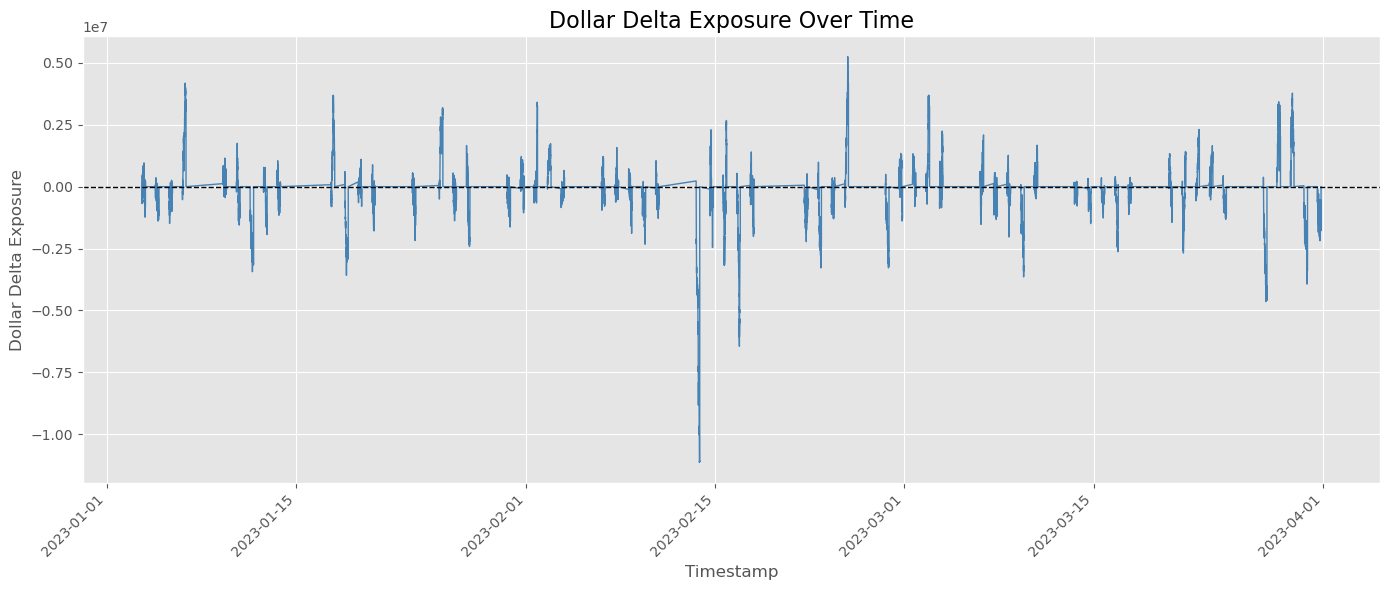

In [10]:
plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=(14,6))

portfolio['portfolio_value'].plot(ax=ax, color='steelblue', linewidth=1)

ax.set_title("Dollar Delta Exposure Over Time", fontsize=16)
ax.set_xlabel("Timestamp", fontsize=12)
ax.set_ylabel("Dollar Delta Exposure", fontsize=12)
ax.axhline(0, color='black', linewidth=1, linestyle='--')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Large positive or negative spikes of the graph shows moments we hold large absolute position in certain symbols. During these periods, even small fluctuations in mid-prices generate portfolio value change.

## 1.3 1.4 General risk metric cal function

Make code more generic for a wider range of risk metrics [using functions]

Cal 30-min(window size) price volatility exposure and 30-min(window size) maximum adverse price move

Window size is parameter which is dependent on alpha horizon of trading strategy. Here we use 30-min window.

In [11]:
# generic risk engine
def compute_risk_metric(values, positions, window, metric_func, **kwargs):
    """Generic rolling-window risk calculator
    
    Args:
        values(np.array): Mark-to-market portfolio values V(t)
        positions(np.array): Position(t) at each timestamp (for exposure-based metrics)
        window(int): Look-ahead window size in minutes.
        metric_func(function): A risk metric function with signature: metric_func(values, positions, t, window, **kwargs)
        kwargs: Extra parameters for metric_func.

    Returns:
        np.array : time series of risk values
    """
    n = len(values)
    out = np.full(n, np.nan)

    for t in range(n - window):
        out[t] = metric_func(values, positions, t, window, **kwargs)

    return out

In [12]:
def vol_exposure(values, positions, t, window):
    """
    Computes window_size realized volatility exposure at time t.
    
    Volatility exposure = std(V(t+1 ... t+window)) * abs(position[t]).
    
    Args:
        values (np.array): Portfolio market values V(t).
        positions (np.array): Portfolio asset position at each t.
        t (int): Current index.
        window (int): Horizon size (e.g., 30 minutes).
    
    Returns:
        float: Realized volatility times absolute position.
    """
    if t + window >= len(values):
        return np.nan
    
    future_vals = values[t+1 : t+window+1]
    realized_vol = np.std(future_vals)
    
    return realized_vol * abs(positions[t])

In [13]:
def MAM(values, positions, t, window):
    """
    Computes the 30-min Maximum Adverse Move (MAM) at time t.
    
    MAM(t) = min(V(s), s in [t, t+window]) - V(t)
    
    Args:
        values (np.array): Portfolio MTM value V(t).
        positions (np.array): Portfolio positions (not used directly here).
        t (int): Current index.
        window (int): Horizon size (e.g., 30 minutes).
    
    Returns:
        float: Worst-case MTM drop over the next window minutes.
    """
    if t + window >= len(values):
        return np.nan
    
    future_vals = values[t : t+window+1]
    return future_vals.min() - values[t]

In [14]:
values = portfolio['portfolio_value'].values
positions = pos.groupby("minute")["position"].sum().values
window = 30

portfolio["vol_exposure_30m"] = compute_risk_metric(values, positions, window, vol_exposure)

portfolio["MAM_30m"] = compute_risk_metric(values, positions, window, MAM)

In [15]:
portfolio

,portfolio_value,vol_exposure_30m,MAM_30m
timestamp,,,
2023-01-03 14:31:00,82544.900,3.743351e+08,-766743.260
2023-01-03 14:32:00,82498.275,3.423561e+08,-766696.635
2023-01-03 14:33:00,-90139.475,9.564562e+07,-594058.885
2023-01-03 14:34:00,-90267.070,9.118926e+07,-593931.290
2023-01-03 14:35:00,-207137.455,3.333751e+08,-477060.905
...,...,...,...
2023-03-31 19:51:00,-1758351.920,NaN,NaN
2023-03-31 19:52:00,-1757613.690,NaN,NaN
2023-03-31 19:53:00,-1757202.830,NaN,NaN


NaN value of columns ['vol_exposure_30m','MAM_30m] at the bottom makes sense because at the end of 30 min points we do not have enought forward looking window data for calculation

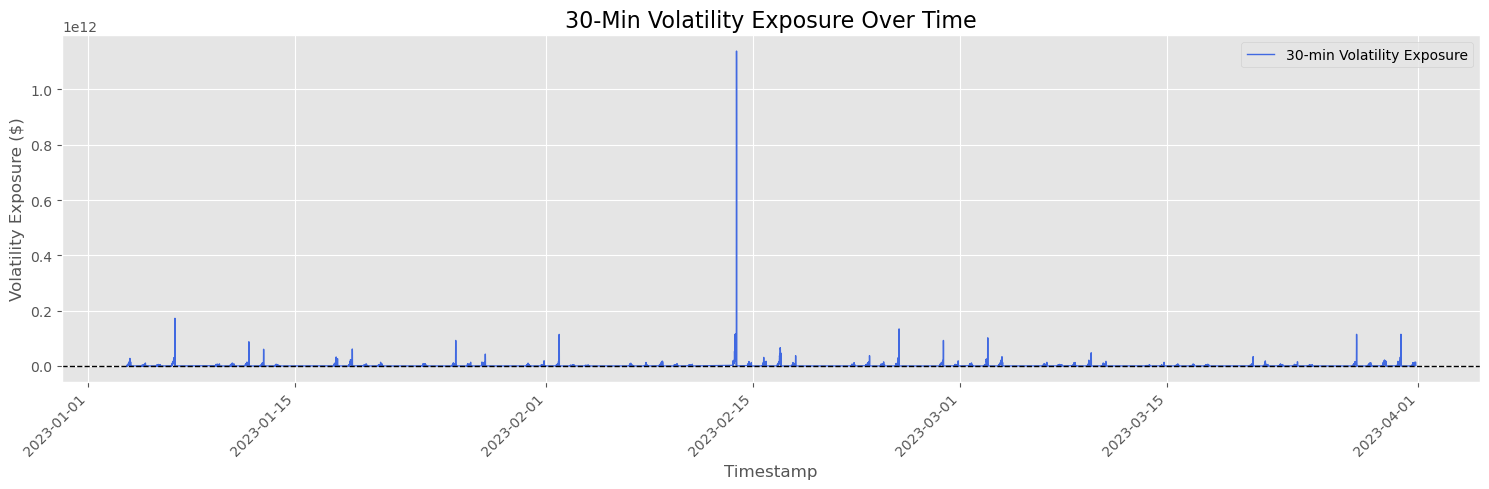

In [16]:
# 30-min Volatility Exposure
plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=(15,5))

portfolio['vol_exposure_30m'].plot(
    ax=ax, 
    linewidth=1, 
    color='royalblue', 
    label='30-min Volatility Exposure'
)

ax.set_title("30-Min Volatility Exposure Over Time", fontsize=16)
ax.set_xlabel("Timestamp", fontsize=12)
ax.set_ylabel("Volatility Exposure ($)", fontsize=12)

ax.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

The volatility exposure measure produces extremely large values (sometimes above 10¹¹–10¹²).
This is not a computational issue. It directly reflects the interaction between large intraday positions and price variability. For example, when the strategy temporarily holds over 40,000 shares of a single name, a relatively small 30-minute MTM volatility (e.g., only a few thousand dollars) is amplified by the position size and produces extremely large volatility exposures.
Hence, this metric highlights the typical risk magnitude associated with the strategy’s large and rapidly changing exposures.

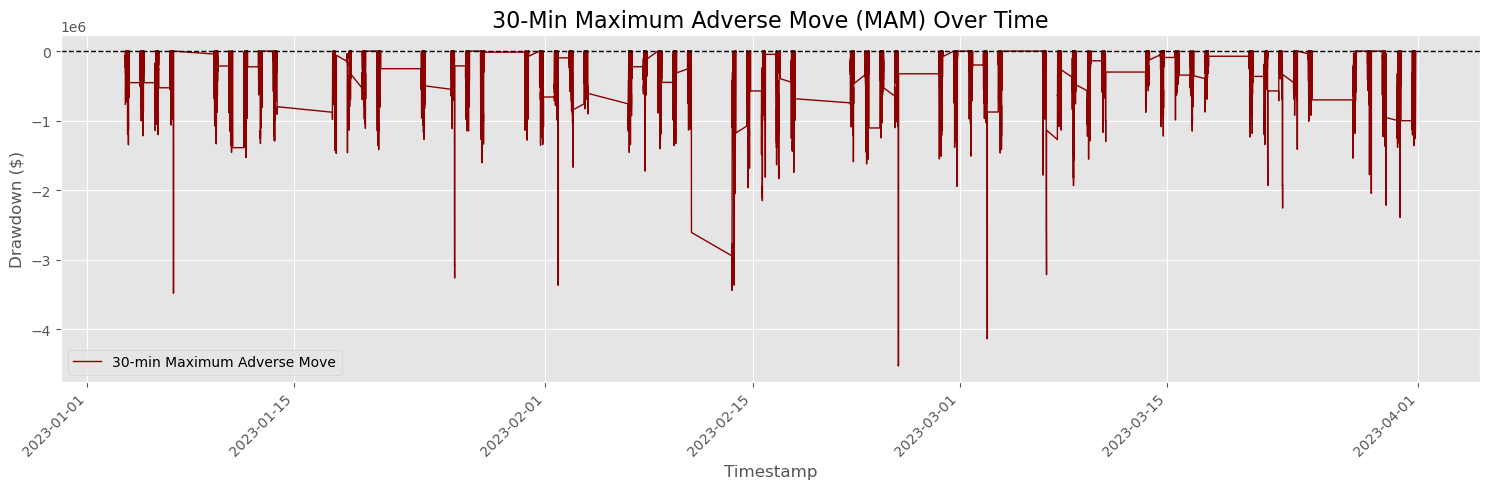

In [17]:
# 30-min MAM
fig, ax = plt.subplots(figsize=(15,5))

portfolio['MAM_30m'].plot(
    ax=ax, 
    linewidth=1, 
    color='darkred', 
    label='30-min Maximum Adverse Move'
)

ax.set_title("30-Min Maximum Adverse Move (MAM) Over Time", fontsize=16)
ax.set_xlabel("Timestamp", fontsize=12)
ax.set_ylabel("Drawdown ($)", fontsize=12)

ax.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

MAM provides a more conservative and path-dependent measure of short-horizon market risk.
The series shows numerous sharp negative spikes, representing the worst 30-minute drawdowns starting from each timestamp. Several MAM events exceed –$2M to –$4M, which correspond to times at which the strategy holds significant directional risk exposure. Unlike volatility, MAM explicitly captures tail risk and the potential for rapid intraday losses.

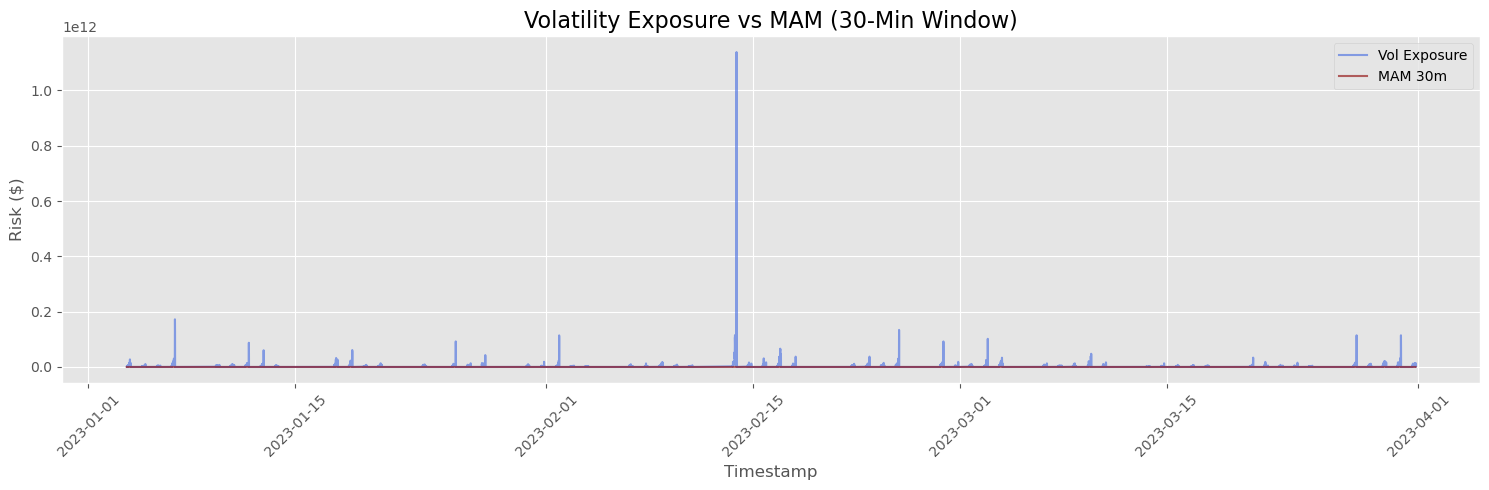

In [18]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(portfolio.index, portfolio['vol_exposure_30m'], alpha=0.6, label="Vol Exposure", color='royalblue')
ax.plot(portfolio.index, portfolio['MAM_30m'], alpha=0.6, label="MAM 30m", color='darkred')

ax.set_title("Volatility Exposure vs MAM (30-Min Window)", fontsize=16)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Risk ($)")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The joint visualization shows that the strategy experiences both substantial typical risk (large volatility exposure) and substantial tail risk (deep MAM spikes).
These exposures arise even though the strategy ultimately flattens its positions; what matters for market risk is the intraday peak exposure, not the final net exposure.
Thus, the risk profile is dominated by short-lived but extremely large directional bets, which makes monitoring 30-minute risk metrics essential.

# Market Surveillance

## 2.1 Metrics to detect algo misbehaviors

**Cancel/Trade Ratio (CTR) = #CANCEL/#FILL**

high level cancellations relative to actual fills may indicate spoofing or layering

if CTR > 5, suspicious;if CTR > 10, highly suspicious

---

**Order/Trade Ratio (OTR) = (#CANCEL+#FILL+#CREATE)/#FILL**

large order generations relative to fills may indicate quote stuffing

stricter metric than CTR

---

**Intraday position flipping rate = #positon reversal/time**

High unit time frequency of flipping of buy/sell actions may indicate market manipulation

---

**Market Impact after fills = mid[t+1]-mid[t] (1 stands for 1 time unite)**

Large immediate mid price move may indicate pushing price or painting the tape

---

**self-trade ratio = #FILL trades where same algo is BOTH buyer&seller/#FILL**

detect wash trading, artificial volume creation

not applicable in this order-book because we do not have buyer_id and seller_id

---

**Order Duration**

show whether your limit order is cancelled within too short time (t<100ms)

not applicable in this minute order-book

## 2.2 2.3 Calculation of Cancel/Trade Ratio (CTR) and Analysis

In [19]:
# global Cancel-to-Trade Ratio
num_cancel = orders[orders['order_status']=='CANCEL'].shape[0]
num_fill   = orders[orders['order_status']=='FILL'].shape[0]

CTR_global = num_cancel / num_fill
CTR_global

1.6669883282786508

Global CTR (1.67) indicates that the strategy behaves normally when viewed across all symbols. But we need to double check for symbol-level.

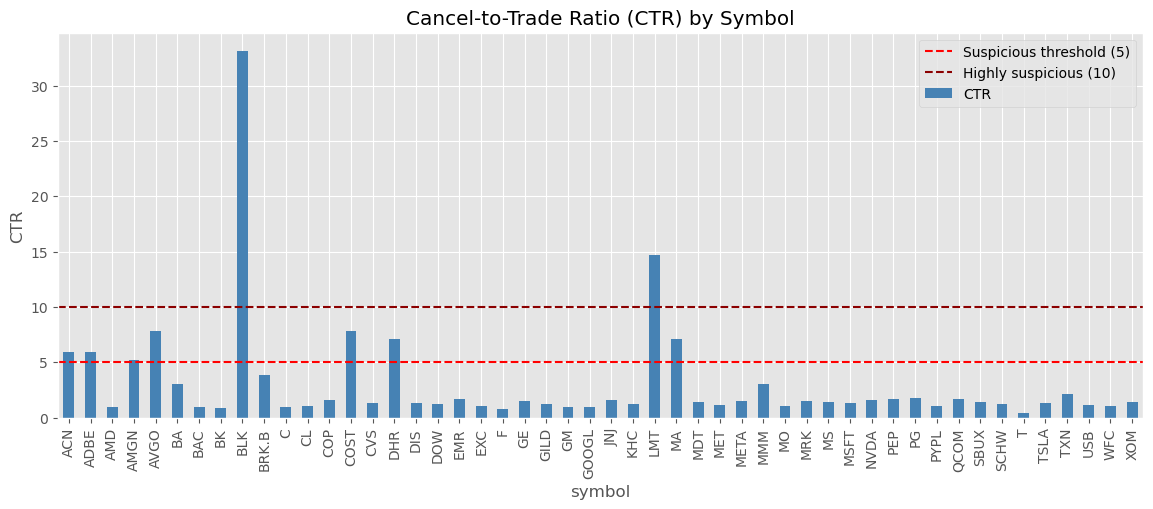

In [20]:
# symbol-level CTR
CTR_symbol = (
    orders.groupby('symbol')['order_status']
        .apply(lambda x: (x=='CANCEL').sum() / (x=='FILL').sum())
        .reset_index(name='CTR')
)

CTR_symbol.set_index('symbol')['CTR'].plot.bar(figsize=(14,5), color='steelblue')
plt.title("Cancel-to-Trade Ratio (CTR) by Symbol")
plt.ylabel("CTR")
plt.axhline(5, color='red', linestyle='--', label='Suspicious threshold (5)')
plt.axhline(10, color='darkred', linestyle='--', label='Highly suspicious (10)')
plt.legend()
plt.show()

CTR across symbols shows asymmetry in algo's order submission behavior.

While many symbols have CTR values in [1,5], 2 symbols (BLK and LMT) have CTR above 10.

CTR have thresholds (>5: suspicious, >10: highly suspicious). This plot indicates that the algo may be placing limit orders that never intended to execute, possibly to influence order book queue or to create misleading liquidity signals.

# Additional risk metrics for a new directional vol alpha strategy using options

We can think about different pnl drivers.

---

**Vega**

sensitivity of option price to implied volatility. Since the alpha is directional IV, Vega is the main driver of PnL. Large Vega means the strategy is highly exposed to vol shocks.

---

**Gamma(Convexity)**

sensitivity of delta to the underlying price. Long-gamma positions can have convexity gains. Short-gamma positions are dangerous. Directional vol strategies often take short-gamma risk. So Gamma exposure must be monitored.

---

**Theta**

Short-vol positions will have positive Theta. Long-vol positions will have negative Theta.

---

**Volga(Convexity of Vega)**

sensitivity of Vega to implied volatility.

---

**Vanna(Cross Sensitivity)**

sensitivity of delta to implied volatility.

---

**Skew/Smile Risk**

risk of IV smile/skew shape changing

---

**Volatility of implied volatility**

realized std of implied volatility

---

**Margin / Leverage Risk**

Large delta/gamma swings will cause margin requirement increases